# Data Processing

The purpose of this notebook is to process the data and keep it separate from the main analysis and visualization. We will write the code unnecessary for the user to interact with such as functions, import libraries, and processing the data into sheets of data we can interpret.

## Table of Contents
* content

## Notebooks
* [Overview Notebook](airpollution.ipynb)
* [Processing Notebook](dataprocessing.ipynb)
* [Analysis Notebook](data-analysis.ipynb)

## Import Libraries

Here are the libraries we are going to use to graph and analyze our data.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.pyplot import figure 
import datetime
import geopandas
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from bokeh.io import output_file, show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure

## Functions

Here are the functions we have created to analyze the datasets we are looking at and graph them to display trends and comparisons.

In [2]:
def concatinate(path):
    files = glob(path + '*csv')
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        df['source_file'] = f.split('/')[-1]
        dfs.append(df)
    
    data = pd.concat(dfs)
    data.columns = ['date', 'source_ozone_aqi', 'ozone_aqi',
                    'source_pm25_aqi', 'pm25_aqi', 'file']
    
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values('date').reset_index(drop=True)
    return data

def rolling_mean(df, series_name, z = 30):
    s = df[['date', series_name]].dropna()
    col = '{}_smoothed'.format(series_name)
    s[col] = s[series_name].rolling(window=z).mean()
    return df.merge(s[['date', col]], how='left')
    return data

def missing_time_analysis(df, series_name):
    print('\nAnalyzing missing time series data for "{}"'.format(series_name))
    s = df[['date', series_name]].dropna()
    s['delta_t'] = s['date'].diff()
    s['delta_days'] = s['delta_t'].apply(lambda t: t.days)
    display(s.head(5))
    s.delta_days.hist(bins=50)
    plt.title('Time Gaps (days)')
    plt.show()
    display(s['delta_days'].describe())
    display(s[s.delta_days > 5]) # show any gaps larger than 5 days
    display(s[s['delta_days'] > 5].groupby('delta_days').size())
        

def aqi_plot(x, y, z): 
    
    temp = ['7/1/1985', '7/1/1986', '7/1/1987', '7/1/1988', '7/1/1989', '7/1/1990', '7/1/1991', '7/1/1992',
        '7/1/1993', '7/1/1994', '7/1/1995', '7/1/1996', '7/1/1997', '7/1/1998', '7/1/1999', '7/1/2000',
        '7/1/2001', '7/1/2002', '7/1/2003', '7/1/2004', '7/1/2005', '7/1/2006', '7/1/2007', '7/1/2008',
        '7/1/2009', '7/1/2010', '7/1/2011', '7/1/2012', '7/1/2013', '7/1/2014', '7/1/2015', '7/1/2016',
        '7/1/2017', '7/1/2018', '7/1/2019', '7/1/2020']

    x['date'] = pd.to_datetime(x['date'])
    y['date'] = pd.to_datetime(temp)
    data = pd.merge(x, y, how = 'left', on = 'date')

    fig, ax = plt.subplots(figsize = (16, 10))
    s = data[['date', 'Annual Ozone']].dropna()
    t = data[['date', 'Annual PM2.5']].dropna()
    ax.plot(data['date'], data['ozone_aqi_smoothed'], alpha = 0.3)
    ax.plot(data['date'], data['pm25_aqi_smoothed'], alpha = 0.3)
    ax.plot(s['date'], s['Annual Ozone'])
    ax.plot(t['date'], t['Annual PM2.5'])
    
    ax.set_title(z + ' Air Quality Trend', fontsize=18)
    ax.set_xlabel('Time (1985-2020)', fontsize=14)
    ax.set_ylabel('Average AQI', fontsize=14)
    ax.legend(['Seasonal Ozone', 'Seasonal PM2.5', 'Annual Ozone', 'Annual PM2.5'], prop={'size': 14})
    ax.grid()

def year_plot(x, y):
    data = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/' + x + '/2020-' + y + '.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data['ozone_aqi'] = data['Ozone_AQI_Value'].rolling(window=7).mean()
    data['pm25_aqi'] = data['PM2.5_AQI_Value'].rolling(window=7).mean()
    ozone = data[['Date', 'ozone_aqi']].dropna()
    particle = data[['Date', 'pm25_aqi']].dropna()
    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(ozone['Date'], ozone['ozone_aqi'])
    ax.plot(particle['Date'], particle['pm25_aqi'])
    ax.set_title(y + ' 2020 AQI Trend', fontsize = 18)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_ylabel('AQI', fontsize = 14)
    ax.legend(['Ozone', 'PM2.5'])
    ax.grid()

    
def plot_all(x):
    

    data = x[0]
    
   
    for f in range (1, len(x)):
        data = pd.merge(data, x[f], how = 'inner', on = 'date')
    ax = data.plot.line('date', ['ozone_aqi_smoothed_x', 
                                 'ozone_aqi_smoothed_y', 'ozone_aqi_smoothed'], figsize = (20, 10), title = 'Ozone Quality Trend', colormap = 'Paired')
    ax.set_xlabel('Time (1985-2020)')
    ax.set_ylabel('Average AQI')
    ax.legend(['NY-NJ-PA', 'TX', 'MA-NH', 'CA', 'PA-NJ-DE-MD', 'WA', 'MN-WI', 'IL-IN-WI', 'GA', 
              'MI', 'FL', 'AZ', 'DC-VA-MD-WV', 'CO', 'MO-IL'])
    ax.grid(True)
    
    bx = data.plot.line('date', ['pm25_aqi_smoothed_x',
                                 'pm25_aqi_smoothed_y', 'pm25_aqi_smoothed'], figsize = (20, 10), title = 'Particulate Matter Quality Trend', colormap = 'Paired')
    bx.set_xlabel('Time (1985-2020)')
    bx.set_ylabel('Average AQI')
    bx.legend(['NY-NJ-PA', 'TX', 'MA-NH', 'CA', 'PA-NJ-DE-MD', 'WA', 'MN-WI', 'IL-IN-WI', 'GA', 
              'MI', 'FL', 'AZ', 'DC-VA-MD-WV', 'CO', 'MO-IL'])
    bx.grid(True)

def production_data(x, z, annual):

    y = x
    file = [z, z, z, z, z]

    y = y.sort_values(by = ['ID SCTG2', 'Year'], ascending = True)

    gasoline_index = [y.loc[y['SCTG2'] == 'Gasoline'].index.values.tolist()]
    gasoline = []
    for i in range (5):
        gasoline.append(x.iat[gasoline_index[0][i], 4])
    
    fuel_oils_index = [y.loc[y['SCTG2'] == 'Fuel oils'].index.values.tolist()]
    fuel_oils = []
    for i in range (5):
        fuel_oils.append(x.iat[fuel_oils_index[0][i], 4])
        
    coal_nec_index = [y.loc[y['SCTG2'] == 'Coal-n.e.c.'].index.values.tolist()]
    coal_nec = []
    for i in range (5):
        coal_nec.append(x.iat[coal_nec_index[0][i], 4])

    motorized_vehicles_index = [y.loc[y['SCTG2'] == 'Motorized vehicles'].index.values.tolist()]
    motorized_vehicles = []
    for i in range (5):
        motorized_vehicles.append(x.iat[motorized_vehicles_index[0][i], 4])
    
    transport_equipment_index = [y.loc[y['SCTG2'] == 'Transport equip.'].index.values.tolist()]
    transport_equipment = []
    for i in range (5):
        transport_equipment.append(x.iat[transport_equipment_index[0][i], 4])
    
    machinery_index = [y.loc[y['SCTG2'] == 'Machinery'].index.values.tolist()]
    machinery = []
    for i in range (5):
        machinery.append(x.iat[machinery_index[0][i], 4])
        
    
        
        
    time = ['2012', '2013', '2014', '2015', '2020']
    
    df = pd.DataFrame({'date' : time,
                       'Gasoline' : gasoline, 
                       'Fuel oils' : fuel_oils,
                       'Coal n.e.c.' : coal_nec,
                       'Motorized vehicles' : motorized_vehicles,
                       'Transport equipment' : transport_equipment,
                       'Machinery' : machinery,
                       'Area' : z})
    
    df['date'] = pd.to_datetime(df['date'])
    
    df = pd.merge(df, annual, how = 'left', on = 'date')
    
    return df

def production_graph(x, z):
    x['date'] = x['date'].dt.strftime('%Y')
    bx = x.plot.bar('date', ['Gasoline', 'Fuel oils', 'Coal n.e.c.', 'Motorized vehicles', 
                             'Transport equipment', 'Machinery'], figsize = (15, 10), title = z, ylim = (0, 300000))
    bx.set_xlabel('Year')
    bx.set_ylabel('Millions of Dollars')
    bx.grid(True)
    bx.legend(['Gasoline', 'Fuel oils', 'Coal n.e.c', 'Motorized vehicles', 'Transport equipment', 'Machinery'])
    
def msa_drop(x):
    data = x
    data.drop(data[(data['NAME'] != 'New York-Newark-Jersey City, NY-NJ-PA') &
                 (data['NAME'] != 'Los Angeles-Long Beach-Anaheim, CA') &
                 (data['NAME'] != 'Chicago-Naperville-Elgin, IL-IN-WI') &
                 (data['NAME'] != 'Dallas-Fort Worth-Arlington, TX') &
                 (data['NAME'] != 'Washington-Arlington-Alexandria, DC-VA-MD-WV') &
                 (data['NAME'] != 'Miami-Fort Lauderdale-Pompano Beach, FL') &
                 (data['NAME'] != 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD') &
                 (data['NAME'] != 'Atlanta-Sandy Springs-Alpharetta, GA') &
                 (data['NAME'] != 'Phoenix-Mesa-Chandler, AZ') &
                 (data['NAME'] != 'Boston-Cambridge-Newton, MA-NH') &
                 (data['NAME'] != 'Detroit-Warren-Dearborn, MI') &
                 (data['NAME'] != 'Seattle-Tacoma-Bellevue, WA') &
                 (data['NAME'] != 'Minneapolis-St. Paul-Bloomington, MN-WI') &
                 (data['NAME'] != 'Denver-Aurora-Lakewood, CO') &
                 (data['NAME'] != 'St. Louis, MO-IL')].index, inplace=True)
    return data

def aqi_annual_average(area, abbr):
    
    year = []
    ozone_aqi = []
    pm25_aqi = []
    for i in range(1985, 2021):
        file = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/' + area + '/' + str(i) + '-' + abbr + '.csv')
        year.append(str(i))
        ozone_aqi.append([file['Ozone_AQI_Value'].mean()])
        pm25_aqi.append([file['PM2.5_AQI_Value'].mean()])
    data = pd.DataFrame({'date' : year,
                         'Annual Ozone' : ozone_aqi,
                         'Annual PM2.5' : pm25_aqi})
    data['date'] = pd.to_datetime(data['date'])
    data['Annual Ozone'] = data['Annual Ozone'].str[0]
    data['Annual PM2.5'] = data['Annual PM2.5'].str[0]
    return data

def correlation(df, title):    
    plt.figure(figsize=(10,10))
    corrMatrix = df.corr()
    #matrix = np.triu(df.corr())
    sns.heatmap(corrMatrix, annot=True, center = 0, fmt = '.1g', cmap = 'seismic', linewidths = 1, 
                linecolor = 'black', square = True)
    plt.title(title)
    plt.show()
    
def annual_list(x, y):
    ozone = []
    pm25 = []
    for f in range (len(x)):
        ozone.append(x[f].iat[27, 1])
        ozone.append(x[f].iat[28, 1])
        ozone.append(x[f].iat[29, 1])
        ozone.append(x[f].iat[30, 1])
        ozone.append(x[f].iat[35, 1])
        
        pm25.append(x[f].iat[27, 2])
        pm25.append(x[f].iat[28, 2])
        pm25.append(x[f].iat[29, 2])
        pm25.append(x[f].iat[30, 2])
        pm25.append(x[f].iat[35, 2])
        
    df = pd.DataFrame({'Year' : y['date'],
                       'O3' : ozone,
                       'PM2.5' : pm25})
    return df

def mobility(x, y, z):
    retail_index = x.loc[x['Type'] == 'Retail and Recreation'].index.values.tolist()
    workplace_index = x.loc[x['Type'] == 'Workplaces'].index.values.tolist()
    transit_index = x.loc[x['Type'] == 'Transit Stations'].index.values.tolist()
    grocery_index = x.loc[x['Type'] == 'Grocery and Pharmacy'].index.values.tolist()
    
    aqi = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/' + y + '/2020-' + z + '.csv')
    aqi['Ozone_AQI_Value'] = aqi['Ozone_AQI_Value'].rolling(window=7).mean()
    aqi['PM2.5_AQI_Value'] = aqi['PM2.5_AQI_Value'].rolling(window=7).mean()
    
    time = []
    retail = []
    workplace = []
    transit = []
    grocery = []
    
    for i in range(175):
        time.append(x.iloc[i, 1])
    
    for i in range(len(retail_index)):
        retail.append(x.iloc[retail_index[i], 3])
        
    for i in range(len(workplace_index)):
        workplace.append(x.iloc[workplace_index[i], 3])
        
    for i in range(len(transit_index)):
        transit.append(x.iloc[transit_index[i], 3])
        
    for i in range(len(grocery_index)):
        grocery.append(x.iloc[grocery_index[i], 3])
    
    data = pd.DataFrame({'Date' : time,
                         'Retail and Recreation' : retail,
                         'Workplace' : workplace,
                         'Transit' : transit,
                         'Grocery' : grocery})
    data['Retail and Recreation'] = data['Retail and Recreation'].rolling(window=7).mean()
    data['Workplace'] = data['Workplace'].rolling(window=7).mean()
    data['Transit'] = data['Transit'].rolling(window=7).mean()
    data['Grocery'] = data['Grocery'].rolling(window=7).mean()
    
    merge = pd.merge(data, aqi, how = 'inner', on = 'Date')
    merge['Date'] = pd.to_datetime(merge['Date'])
    return merge

def plot_mobility(x):
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.plot(x['Date'], x['Ozone AQI'])
    ax.plot(x['Date'], x['PM2.5 AQI'])
    ax.plot(x['Date'], x['Retail and Recreation'])
    ax.plot(x['Date'], x['Workplace'])
    ax.plot(x['Date'], x['Transit'])
    ax.plot(x['Date'], x['Grocery'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Number in AQI and Commute Changes')
    ax.legend(['Ozone AQI', 'PM2.5 AQI', 'Retail and Recreation', 'Workplace', 'Transit', 'Grocery'])
    ax.grid()

def plot_commuting(df, title):
    fig = plt.figure(figsize=(5,4))
    x = df['Date']
    y1 = df['Workplace']
    y2 = df['Retail and Recreation']
    y3 = df['Transit']
    y4 = df['Grocery']
    y5 = df['PM2.5_AQI_Value']
    plt.scatter(x, y1, label='Workplace Commuting')
    plt.scatter(x, y2, label= 'Retail and Recreation')
    plt.scatter(x, y3, label = 'Transit')
    plt.scatter(x, y4, label = 'Grocery')
    plt.scatter(x, y5, label='PM2.5')
    plt.title(title)
    plt.legend(loc=3)
    plt.show()

def gdp_production(metro, aqi):
    gdp_time = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
    aqi_time = ['1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
                '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013','2014', '2015', '2016', '2017', '2018', '2019', '2020']
    df = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/Metro-Production-GDP.csv')
    df = df.replace({'(D)' : None})
    area = df.loc[df['GeoName'] == metro]
    
    mining = []
    utilities = []
    construction = []
    manufacturing = []
    transportation = []
    natural = []
    
    gdp_mining = area.loc[area['Description'] == '    Mining, quarrying, and oil and gas extraction']
    gdp_utilities = area.loc[area['Description'] == '    Utilities']
    gdp_construction = area.loc[area['Description'] == '    Construction']
    gdp_manufacturing = area.loc[area['Description'] == '    Manufacturing']
    gdp_transportation = area.loc[area['Description'] == '    Transportation and warehousing']
    gdp_natural = area.loc[area['Description'] == 'Natural resources and mining']
    
    for i in range(4, 22):
        
        if gdp_mining.iloc[0, i] != None:
            mining.append((int)(gdp_mining.iloc[0, i]))
        else:
            mining.append(None)
        
        if gdp_utilities.iloc[0, i] != None:
            utilities.append((int)(gdp_utilities.iloc[0, i]))
        else:
            utilities.append(None)
            
        if gdp_construction.iloc[0, i] != None:
            construction.append((int)(gdp_construction.iloc[0, i]))
        else:
            construction.append(None)
        
        if gdp_manufacturing.iloc[0, i] != None:
            manufacturing.append((int)(gdp_manufacturing.iloc[0, i]))
        else:
            manufacturing.append(None)
        
        if gdp_transportation.iloc[0, i] != None:
            transportation.append((int)(gdp_transportation.iloc[0, i]))
        else:
            transportation.append(None)
        
        if gdp_natural.iloc[0, i] != None:
            natural.append((int)(gdp_natural.iloc[0, i]))
        else:
            natural.append(None)
            
    data = pd.DataFrame({'date' : gdp_time,
                         'Mining, quarrying, oil and gas extraction' : mining,
                            'Utilities' : utilities,
                            'Construction' : construction,
                            'Manufacturing' : manufacturing,
                            'Transportation and warehousing' : transportation,
                            'Natural resources and mining' : natural})
    data['date'] = pd.to_datetime(data['date'])
    aqi['date'] = aqi_time
    aqi['date'] = pd.to_datetime(aqi['date'])
    data = pd.merge(data, aqi, how = 'left', on = 'date')

    return data

def gdp_plot(x, y):
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    ax1.plot(x['date'], x['Mining, quarrying, oil and gas extraction'], alpha = 0.4)
    ax1.plot(x['date'], x['Utilities'], alpha = 0.4)
    ax1.plot(x['date'], x['Construction'], alpha = 0.4)
    ax1.plot(x['date'], x['Manufacturing'], alpha = 0.4)
    ax1.plot(x['date'], x['Natural resources and mining'], alpha = 0.4)
    ax1.plot(x['date'], x['Transportation and warehousing'], alpha = 0.4)
    ax2.plot(x['date'], x['Annual Ozone'], '--', linewidth = 5)
    ax2.plot(x['date'], x['Annual PM2.5'], '--', linewidth = 5)
    ax2.grid(b=False)
    
    ax1.legend(['Mining, quarrying, oil and gas extraction', 'Utilities', 'Construction', 'Manufacturing', 
               'Natural resources and mining', 'Transportation and warehousing'], loc = 'upper left') 
    ax2.legend(['Annual Ozone', 'Annual PM2.5'], loc = 'upper right')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('GDP (In Hundreds of Millions of Dollars)')
    ax2.set_ylabel('AQI')
    ax1.set_title(y)
    ax1.grid()

def mobility_plot(x, y):
    
    x['Smoothed O3'] = x['Ozone_AQI_Value'].rolling(window=7).mean()
    x['Smoothed PM2.5'] = x['PM2.5_AQI_Value'].rolling(window=7).mean()
    
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    ax1.plot(x['Date'], x['Grocery'], alpha = 0.4)
    ax1.plot(x['Date'], x['Transit'], alpha = 0.4)
    ax1.plot(x['Date'], x['Workplace'], alpha = 0.4)
    ax1.plot(x['Date'], x['Retail and Recreation'], alpha = 0.4)
    ax2.plot(x['Date'], x['Smoothed O3'], '--', linewidth = 5)
    ax2.plot(x['Date'], x['Smoothed PM2.5'], '--', linewidth = 5)
    ax2.grid(b=False)
    
    ax1.legend(['Grocery', 'Transit', 'Workplace', 'Retail and Recreation'], loc = 'upper left') 
    ax2.legend(['Ozone', 'PM2.5'], loc = 'upper right')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Percent Change From Baseline Traveling')
    ax2.set_ylabel('AQI')
    ax1.set_title(y)
    ax1.grid()

### Simulation Functions

Functions for the simulation of the map!

In [3]:
def plot_year_aqi(msa, index, p, year, us):
    msa_names = ['GA', 'MA-NH', 'TX', 'CO', 'MI', 'IL-IN-WI', 'CA', 'FL', 
             'MN-WI', 'NY-NJ-PA','PA-NJ-DE-MD','AZ', 'MO-IL', 'WA', 'DC-VA-MD-WV']
    msa['NAMELSAD'] = msa_names
    
    aqi = [ga_annual.iloc[index, p], ma_nh_annual.iloc[index, p], tx_annual.iloc[index, p], 
               co_annual.iloc[index, p], mi_annual.iloc[index, p], il_in_wi_annual.iloc[index, p], 
               ca_annual.iloc[index, p], fl_annual.iloc[index, p], mn_wi_annual.iloc[index, p], 
               ny_nj_pa_annual.iloc[index, p], pa_nj_de_md_annual.iloc[index, p], 
               az_annual.iloc[index, p], mo_il_annual.iloc[index, p], wa_annual.iloc[index, p], 
               dc_va_md_wv_annual.iloc[index, p]]  
    temp = pd.DataFrame({'NAMELSAD' : msa_names,
                          year : aqi})
    display = pd.merge(msa, temp, how = 'left', on = 'NAMELSAD')
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    fig.set_figheight(20)
    fig.set_figwidth(20)
    ax.set_ylim([23, 50])
    ax.set_xlim([-130,-60])
    ax.set_title(year + ' MSA Air Quality', fontsize = 20)
    ax.set_axis_off()
    us.plot(ax=ax, color='white', edgecolor='k')
    #labels = ['Good', 'Moderate', 'Unhealthy For Sensitive Groups', 'Unhealthy', 'Very Unhealthy']
    divider = make_axes_locatable(ax)
    display.plot(ax = ax, alpha = 0.3, edgecolor = 'k', column = year, legend = True,
                       cax = divider.append_axes("right", size="6%", pad=0.1))
    plt.show()
    

In [4]:
def simulation(msa, us):
    year = ''
    while(year != 'STOP'):
        year = input('Enter a year from 1985-2020 to see the AQI, or type STOP to stop the simulation: ' )
        if year != 'STOP':
            pollutant = input('Enter O3 or PM2.5 to see the year AQI for that pollutant: ')
            if year == '1985' and pollutant == 'O3':
                plot_year_aqi(msa, 0, 1, year, us)
            elif year == '1985' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 0, 2, year, us)
            elif year == '1986' and pollutant == 'O3':
                plot_year_aqi(msa, 1, 1, year, us)
            elif year == '1986' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 1, 2, year, us)
            elif year == '1987' and pollutant == 'O3':
                plot_year_aqi(msa, 2, 1, year, us)
            elif year == '1987' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 2, 2, year, us)
            elif year == '1988' and pollutant == 'O3':
                plot_year_aqi(msa, 3, 1, year, us)
            elif year == '1988' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 3, 2, year, us)
            elif year == '1989' and pollutant == 'O3':
                plot_year_aqi(msa, 4, 1, year, us)
            elif year == '1989' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 4, 2, year, us)
            elif year == '1990' and pollutant == 'O3':
                plot_year_aqi(msa, 5, 1, year, us)
            elif year == '1990' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 5, 2, year, us)
            elif year == '1991' and pollutant == 'O3':
                plot_year_aqi(msa, 6, 1, year, us)
            elif year == '1991' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 6, 2, year, us)
            elif year == '1992' and pollutant == 'O3':
                plot_year_aqi(msa, 7, 1, year, us)
            elif year == '1992' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 7, 2, year, us)
            elif year == '1993' and pollutant == 'O3':
                plot_year_aqi(msa, 8, 1, year, us)
            elif year == '1993' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 8, 2, year, us)
            elif year == '1994' and pollutant == 'O3':
                plot_year_aqi(msa, 9, 1, year, us)
            elif year == '1994' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 9, 2, year, us)
            elif year == '1995' and pollutant == 'O3':
                plot_year_aqi(msa, 10, 1, year, us)
            elif year == '1995' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 10, 2, year, us)
            elif year == '1996' and pollutant == 'O3':
                plot_year_aqi(msa, 11, 1, year, us)
            elif year == '1996' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 11, 2, year, us)
            elif year == '1997' and pollutant == 'O3':
                plot_year_aqi(msa, 12, 1, year, us)
            elif year == '1997' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 12, 2, year, us)
            elif year == '1998' and pollutant == 'O3':
                plot_year_aqi(msa, 13, 1, year, us)
            elif year == '1998' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 13, 2, year, us)
            elif year == '1999' and pollutant == 'O3':
                plot_year_aqi(msa, 14, 1, year, us)
            elif year == '1999' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 14, 2, year, us)
            elif year == '2000' and pollutant == 'O3':
                plot_year_aqi(msa, 15, 1, year, us)
            elif year == '2000' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 15, 2, year, us)
            elif year == '2001' and pollutant == 'O3':
                plot_year_aqi(msa, 16, 1, year, us)
            elif year == '2001' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 16, 2, year, us)
            elif year == '2002' and pollutant == 'O3':
                plot_year_aqi(msa, 17, 1, year, us)
            elif year == '2002' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 17, 2, year, us)
            elif year == '2003' and pollutant == 'O3':
                plot_year_aqi(msa, 18, 1, year, us)
            elif year == '2003' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 18, 2, year, us)
            elif year == '2004' and pollutant == 'O3':
                plot_year_aqi(msa, 19, 1, year, us)
            elif year == '2004' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 19, 2, year, us)
            elif year == '2005' and pollutant == 'O3':
                plot_year_aqi(msa, 20, 1, year, us)
            elif year == '2005' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 20, 2, year, us)
            elif year == '2006' and pollutant == 'O3':
                plot_year_aqi(msa, 21, 1, year, us)
            elif year == '2006' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 21, 2, year, us)
            elif year == '2007' and pollutant == 'O3':
                plot_year_aqi(msa, 22, 1, year, us)
            elif year == '2007' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 22, 2, year, us)
            elif year == '2008' and pollutant == 'O3':
                plot_year_aqi(msa, 23, 1, year, us)
            elif year == '2008' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 23, 2, year, us)
            elif year == '2009' and pollutant == 'O3':
                plot_year_aqi(msa, 24, 1, year, us)
            elif year == '2009' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 24, 2, year, us)
            elif year == '2010' and pollutant == 'O3':
                plot_year_aqi(msa, 25, 1, year, us)
            elif year == '2010' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 25, 2, year, us)
            elif year == '2011' and pollutant == 'O3':
                plot_year_aqi(msa, 26, 1, year, us)
            elif year == '2011' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 26, 2, year, us)
            elif year == '2012' and pollutant == 'O3':
                plot_year_aqi(msa, 27, 1, year, us)
            elif year == '2012' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 27, 2, year, us)
            elif year == '2013' and pollutant == 'O3':
                plot_year_aqi(msa, 28, 1, year, us)
            elif year == '2013' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 28, 2, year, us)
            elif year == '2014' and pollutant == 'O3':
                plot_year_aqi(msa, 29, 1, year, us)
            elif year == '2014' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 29, 2, year, us)
            elif year == '2015' and pollutant == 'O3':
                plot_year_aqi(msa, 30, 1, year, us)
            elif year == '2015' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 30, 2, year, us)
            elif year == '2016' and pollutant == 'O3':
                plot_year_aqi(msa, 31, 1, year, us)
            elif year == '2016' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 31, 2, year, us)
            elif year == '2017' and pollutant == 'O3':
                plot_year_aqi(msa, 32, 1, year, us)
            elif year == '2017' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 32, 2, year, us)
            elif year == '2018' and pollutant == 'O3':
                plot_year_aqi(msa, 33, 1, year, us)
            elif year == '2018' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 33, 2, year, us)
            elif year == '2019' and pollutant == 'O3':
                plot_year_aqi(msa, 34, 1, year, us)
            elif year == '2019' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 34, 2, year, us)
            elif year == '2020' and pollutant == 'O3':
                plot_year_aqi(msa, 35, 1, year, us)
            elif year == '2020' and pollutant == 'PM2.5':
                plot_year_aqi(msa, 35, 2, year, us)

In [5]:
def energy_simulation(x):
    state = ''
    state_initials = ['ME', 'MA', 'NH', 'NJ', 'NY', 'PA', 'IL', 'IN', 'MI', 'WI', 'MN', 'MO', 'DE', 'FL',
                  'GA', 'MD', 'VA', 'WV', 'TX', 'AZ', 'CO', 'CA', 'WA']
    while(state != 'STOP'):
        print('List of States: ME, MA, NH, NJ, NY, PA, IL, IN, MI, WI, MN, MO, DE, FL, GA, MD, VA, WV, TX, AZ, CO, CA, WA')
        state = input('Enter a state from the list above to see the energy used, or type STOP to stop the simulation. ')
        if state != 'STOP':
            fig, ax = plt.subplots(figsize = (16, 10))
            ax.plot(x['Year'], x['Coal-' + state])
            ax.plot(x['Year'], x['Natural-Gas-' + state])
            ax.plot(x['Year'], x['Nuclear-' + state])
            ax.plot(x['Year'], x['Hydroelectric-' + state])
            ax.plot(x['Year'], x['Wind-' + state])
            ax.plot(x['Year'], x['Solar-' + state])
            ax.set_title(state + ' Energy Output Trend', fontsize=18)
            ax.set_xlabel('Year', fontsize=14)
            ax.set_ylabel('Energy Output (thousands of megawatt hours)', fontsize=14)
            ax.legend(['Coal', 'Natural Gas', 'Nuclear', 'Hydroelectric', 'Wind', 'Solar'], prop={'size': 14})
            ax.grid()
            plt.show()
def energy(x, y, state):
    energy_time = ['7/1/2001', '7/1/2002', '7/1/2003', '7/1/2004', '7/1/2005', '7/1/2006', '7/1/2007', '7/1/2008',
        '7/1/2009', '7/1/2010', '7/1/2011', '7/1/2012', '7/1/2013', '7/1/2014', '7/1/2015', '7/1/2016',
        '7/1/2017', '7/1/2018', '7/1/2019']
    annual_time = ['7/1/1985', '7/1/1986', '7/1/1987', '7/1/1988', '7/1/1989', '7/1/1990', '7/1/1991', '7/1/1992',
        '7/1/1993', '7/1/1994', '7/1/1995', '7/1/1996', '7/1/1997', '7/1/1998', '7/1/1999', '7/1/2000',
        '7/1/2001', '7/1/2002', '7/1/2003', '7/1/2004', '7/1/2005', '7/1/2006', '7/1/2007', '7/1/2008',
        '7/1/2009', '7/1/2010', '7/1/2011', '7/1/2012', '7/1/2013', '7/1/2014', '7/1/2015', '7/1/2016',
        '7/1/2017', '7/1/2018', '7/1/2019', '7/1/2020']
    
    energy = pd.DataFrame({'date' : energy_time,
                           'Coal' : x['Coal-' + state],
                           'Natural Gas' : x['Natural-Gas-' + state],
                           'Nuclear' : x['Nuclear-' + state],
                           'Hydroelectric' : x['Hydroelectric-' + state],
                           'Wind' : x['Wind-' + state],
                           'Solar' : x['Solar-' + state]})
    energy['date'] = pd.to_datetime(energy['date'])
    energy = energy.sort_values('date', ascending = True)
    
    
    y['date'] = pd.to_datetime(annual_time)
    energy = pd.merge(energy, y, how = 'left', on = 'date')
    
    coal_percent = []
    natural_gas_percent = []
    nuclear_percent = []
    hydroelectric_percent = []
    wind_percent = []
    solar_percent = []
    
    energy = energy.fillna(0)
    
    for i in range(19):
        
        coal_percent.append(energy.iloc[i, 1] / (energy.iloc[i, 1] + 
                                                energy.iloc[i, 2] + 
                                                energy.iloc[i, 3] + 
                                                energy.iloc[i, 4] + 
                                                energy.iloc[i, 5] +
                                                energy.iloc[i, 6]))
        natural_gas_percent.append(energy.iloc[i, 2] / (energy.iloc[i, 1] + 
                                                energy.iloc[i, 2] + 
                                                energy.iloc[i, 3] + 
                                                energy.iloc[i, 4] + 
                                                energy.iloc[i, 5] +
                                                energy.iloc[i, 6]))
        nuclear_percent.append(energy.iloc[i, 3] / (energy.iloc[i, 1] + 
                                                energy.iloc[i, 2] + 
                                                energy.iloc[i, 3] + 
                                                energy.iloc[i, 4] + 
                                                energy.iloc[i, 5] +
                                                energy.iloc[i, 6]))
        hydroelectric_percent.append(energy.iloc[i, 4] / (energy.iloc[i, 1] + 
                                                energy.iloc[i, 2] + 
                                                energy.iloc[i, 3] + 
                                                energy.iloc[i, 4] + 
                                                energy.iloc[i, 5] +
                                                energy.iloc[i, 6]))
        wind_percent.append(energy.iloc[i, 5] / (energy.iloc[i, 1] + 
                                                energy.iloc[i, 2] + 
                                                energy.iloc[i, 3] + 
                                                energy.iloc[i, 4] + 
                                                energy.iloc[i, 5] +
                                                energy.iloc[i, 6]))
        solar_percent.append(energy.iloc[i, 6] / (energy.iloc[i, 1] + 
                                                energy.iloc[i, 2] + 
                                                energy.iloc[i, 3] + 
                                                energy.iloc[i, 4] + 
                                                energy.iloc[i, 5] +
                                                energy.iloc[i, 6]))
    
    energy['Coal Percent'] = coal_percent
    energy['Natural Gas Percent'] = natural_gas_percent
    energy['Nuclear Percent'] = nuclear_percent
    energy['Hydroelectric Percent'] = hydroelectric_percent
    energy['Wind Percent'] = wind_percent
    energy['Solar Percent'] = solar_percent
    
    return energy


def energy_percent(x):
    
    energy = pd.DataFrame({'date' : x['date'],
                           'Coal Percent' : x['Coal Percent'],
                           'Natural Gas Percent' : x['Natural Gas Percent'],
                           'Nuclear Percent' : x['Nuclear Percent'],
                           'Hydroelectric Percent' : x['Hydroelectric Percent'],
                           'Wind' : x['Wind Percent'],
                           'Solar' : x['Solar Percent'],
                           'Ozone' : x['Annual Ozone'],
                           'PM2.5' : x['Annual PM2.5']})

    return energy

def plot_energy(x, y):
    fig, ax1 = plt.subplots(figsize=(16, 10))
    ax2 = ax1.twinx()
    ax1.plot(x['date'], x['Coal Percent'], alpha = 0.5)
    ax1.plot(x['date'], x['Natural Gas Percent'], alpha = 0.5)
    ax1.plot(x['date'], x['Nuclear Percent'], alpha = 0.5)
    ax1.plot(x['date'], x['Hydroelectric Percent'], alpha = 0.5)
    ax1.plot(x['date'], x['Wind Percent'], alpha = 0.5)
    ax1.plot(x['date'], x['Solar Percent'], alpha = 0.5)
    ax2.plot(x['date'], x['Annual Ozone'], '--', linewidth = 5)
    ax2.plot(x['date'], x['Annual PM2.5'], '--', linewidth = 5)
    ax1.set_ylabel('Percentage of Energy')
    ax2.set_ylabel('AQI')
    ax1.legend(['Coal', 'Natural Gas', 'Nuclear', 'Hydroelectric', 'Wind', 'Solar'], loc = 'upper left')
    ax2.legend(['O3', 'PM2.5'], loc = 'upper right')
    ax1.set_title(y)
    ax1.grid()

def pie_energy_2020(x, y):
    percentage = [x.iloc[18, 9], x.iloc[18, 10], x.iloc[18, 11], x.iloc[18, 12], x.iloc[18, 13], x.iloc[18, 14]]
    df = pd.DataFrame({'date' : x['date'],
                       '2020' : percentage},
                      index = ['Coal', 'Natural Gas', 'Nuclear',
                               'Hydroelectric', 'Wind', 'Solar'])
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.pie(df['2020'], labels = df.index, autopct='%1.0f%%', shadow = True, explode = [.05, .05, .05, .05, .05, .05])
    ax.legend(['Coal', 'Natural Gas', 'Nuclear', 'Hydroelectric', 'Wind', 'Solar'], loc = 1)

## Processing The Data

Here we access the file locations for each metropolitan statistical area and use the methods to create dataframes we can work with so we can plot them.

In [6]:
ny_nj_pa_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/NewYork-Newark-JerseyCity/')
ny_nj_pa = rolling_mean(ny_nj_pa_files, 'ozone_aqi')
ny_nj_pa = rolling_mean(ny_nj_pa, 'pm25_aqi')
ny_nj_pa_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/NY-NJ-PA-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
ny_nj_pa_annual = aqi_annual_average('NewYork-Newark-JerseyCity', 'NY-NJ-PA')
ny_nj_pa_production = production_data(ny_nj_pa_production_files, 'NY-NJ-PA', ny_nj_pa_annual)
#ny_nj_pa_2020 = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/NewYork-Newark-JerseyCity/2020-NY-NJ-PA.csv')
ny_nj_pa_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/NY-NJ-PA-Mobility.csv')
ny_nj_pa_mobility = mobility(ny_nj_pa_mobility_files, 'NewYork-Newark-JerseyCity', 'NY-NJ-PA')

il_in_wi_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Chicago-Naperville-Elgin/')
il_in_wi = rolling_mean(il_in_wi_files, 'ozone_aqi')
il_in_wi = rolling_mean(il_in_wi, 'pm25_aqi')
il_in_wi_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/IL-IN-WI-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
il_in_wi_annual = aqi_annual_average('Chicago-Naperville-Elgin', 'IL-IN-WI')
il_in_wi_production = production_data(il_in_wi_production_files, 'IL-IN-WI', il_in_wi_annual)
il_in_wi_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/IL-IN-WI-Mobility.csv')
il_in_wi_mobility = mobility(il_in_wi_mobility_files, 'Chicago-Naperville-Elgin', 'IL-IN-WI')

tx_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Dallas-FortWorth-Arlington/')
tx = rolling_mean(tx_files, 'ozone_aqi')
tx = rolling_mean(tx, 'pm25_aqi')
tx_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/TX-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
tx_annual = aqi_annual_average('Dallas-FortWorth-Arlington', 'TX')
tx_production = production_data(tx_production_files, 'TX', tx_annual)
tx_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/TX-Mobility.csv')
tx_mobility = mobility(tx_mobility_files, 'Dallas-FortWorth-Arlington', 'TX')

ga_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Atlanta-SandySprings-Roswell/')
ga = rolling_mean(ga_files, 'ozone_aqi')
ga = rolling_mean(ga, 'pm25_aqi')
ga_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/GA-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
ga_annual = aqi_annual_average('Atlanta-SandySprings-Roswell', 'GA')
ga_production = production_data(ga_production_files, 'GA', ga_annual)
ga_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/GA-Mobility.csv')
ga_mobility = mobility(ga_mobility_files, 'Atlanta-SandySprings-Roswell', 'GA')

ma_nh_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Boston-Cambridge-Newton/')
ma_nh = rolling_mean(ma_nh_files, 'ozone_aqi')
ma_nh = rolling_mean(ma_nh, 'pm25_aqi')
ma_nh_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/MA-NH-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
ma_nh_annual = aqi_annual_average('Boston-Cambridge-Newton', 'MA-NH')
ma_nh_production = production_data(ma_nh_production_files, 'MA-NH', ma_nh_annual)
ma_nh_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/MA-NH-Mobility.csv')
ma_nh_mobility = mobility(ma_nh_mobility_files, 'Boston-Cambridge-Newton', 'MA-NH')

mi_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Detroit-Warren-Dearborn/')
mi = rolling_mean(mi_files, 'ozone_aqi')
mi = rolling_mean(mi, 'pm25_aqi')
mi_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/MI-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
mi_annual = aqi_annual_average('Detroit-Warren-Dearborn', 'MI')
mi_production = production_data(mi_production_files, 'MI', mi_annual)
# year test: mi_2020 = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Detroit-Warren-Dearborn/2020-MI.csv')
mi_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/MI-Mobility.csv')
mi_mobility = mobility(mi_files, 'Detroit-Warren-Dearborn', 'MI')

ca_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/LosAngeles-LongBeach-Anaheim/')
ca = rolling_mean(ca_files, 'ozone_aqi')
ca = rolling_mean(ca, 'pm25_aqi')
ca_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/CA-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
ca_annual = aqi_annual_average('LosAngeles-LongBeach-Anaheim', 'CA')
ca_production = production_data(ca_production_files, 'CA', ca_annual)
ca_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/CA-Mobility.csv')
ca_mobility = mobility(ny_nj_pa_mobility_files, 'LosAngeles-LongBeach-Anaheim', 'CA')

fl_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Miami-FortLauderdale-WestPalmBeach/')
fl = rolling_mean(fl_files, 'ozone_aqi')
fl = rolling_mean(fl, 'pm25_aqi')
fl_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/FL-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
fl_annual = aqi_annual_average('Miami-FortLauderdale-WestPalmBeach', 'FL')
fl_production = production_data(fl_production_files, 'FL', fl_annual)
fl_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/FL-Mobility.csv')
fl_mobility = mobility(fl_mobility_files, 'Miami-FortLauderdale-WestPalmBeach', 'FL')

pa_nj_de_md_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Philadelphia-Camden-Wilmington/')
pa_nj_de_md = rolling_mean(pa_nj_de_md_files, 'ozone_aqi')
pa_nj_de_md = rolling_mean(pa_nj_de_md, 'pm25_aqi')
pa_nj_de_md_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/PA-NJ-DE-MD-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
pa_nj_de_md_annual = aqi_annual_average('Philadelphia-Camden-Wilmington', 'PA-NJ-DE-MD')
pa_nj_de_md_production = production_data(pa_nj_de_md_production_files, 'PA-NJ-DE-MD', pa_nj_de_md_annual)
pa_nj_de_md_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/PA-NJ-DE-MD-Mobility.csv')
pa_nj_de_md_mobility = mobility(pa_nj_de_md_mobility_files, 'Philadelphia-Camden-Wilmington', 'PA-NJ-DE-MD')

az_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Phoenix-Mesa-Scottsdale/')
az = rolling_mean(az_files, 'ozone_aqi')
az = rolling_mean(az, 'pm25_aqi')
az_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/AZ-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
az_annual = aqi_annual_average('Phoenix-Mesa-Scottsdale', 'AZ')
az_production = production_data(az_production_files, 'AZ', az_annual)
# year test: az_2020 = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Phoenix-Mesa-Scottsdale/2020-AZ.csv')
az_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/AZ-Mobility.csv')
az_mobility = mobility(az_mobility_files, 'Phoenix-Mesa-Scottsdale', 'AZ')

wa_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Seattle-Tacoma-Bellevue/')
wa = rolling_mean(wa_files, 'ozone_aqi')
wa = rolling_mean(wa, 'pm25_aqi')
wa_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/WA-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
wa_annual = aqi_annual_average('Seattle-Tacoma-Bellevue', 'WA')
wa_production = production_data(wa_production_files, 'WA', wa_annual)
wa_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/WA-Mobility.csv')
wa_mobility = mobility(wa_mobility_files, 'Seattle-Tacoma-Bellevue', 'WA')

dc_va_md_wv_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Washington-Arlington-Alexandria/')
dc_va_md_wv = rolling_mean(dc_va_md_wv_files, 'ozone_aqi')
dc_va_md_wv = rolling_mean(dc_va_md_wv, 'pm25_aqi')
dc_va_md_wv_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/DC-VA-MD-WV-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
dc_va_md_wv_annual = aqi_annual_average('Washington-Arlington-Alexandria', 'DC-VA-MD-WV')
dc_va_md_wv_production = production_data(dc_va_md_wv_production_files, 'DC-VA-MD-WV', dc_va_md_wv_annual)
dc_va_md_wv_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/DC-VA-MD-WV-Mobility.csv')
dc_va_md_wv_mobility = mobility(dc_va_md_wv_mobility_files, 'Washington-Arlington-Alexandria', 'DC-VA-MD-WV')

mn_wi_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Minneapolis-St.Paul-Bloomington/')
mn_wi = rolling_mean(mn_wi_files, 'ozone_aqi')
mn_wi = rolling_mean(mn_wi, 'pm25_aqi')
mn_wi_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/MN-WI-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
mn_wi_annual = aqi_annual_average('Minneapolis-St.Paul-Bloomington', 'MN-WI')
mn_wi_production = production_data(mn_wi_production_files, 'MN-WI', mn_wi_annual)
mn_wi_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/MN-WI-Mobility.csv')
mn_wi_mobility = mobility(mn_wi_mobility_files, 'Minneapolis-St.Paul-Bloomington', 'MN-WI')

co_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Denver-Aurora-Lakewood/')
co = rolling_mean(co_files, 'ozone_aqi')
co = rolling_mean(co, 'pm25_aqi')
co_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/CO-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
co_annual = aqi_annual_average('Denver-Aurora-Lakewood', 'CO')   
co_production = production_data(co_production_files, 'CO', co_annual)                               
# year test: co_2020 = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Areas/Denver-Aurora-Lakewood/2020-CO.csv')
co_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/CO-Mobility.csv')
co_mobility = mobility(co_mobility_files, 'Denver-Aurora-Lakewood', 'CO')

mo_il_files = concatinate('/Users/smaslam/Desktop/airpollution/airpollution/Areas/St.Louis/')
mo_il = rolling_mean(mo_il_files, 'ozone_aqi')
mo_il = rolling_mean(mo_il, 'pm25_aqi')
mo_il_production_files = pd.DataFrame(pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/MO-IL-Production.csv',
                                         sep = r'\s*,\s*', engine = 'python'))
mo_il_annual = aqi_annual_average('St.Louis', 'MO-IL')
mo_il_production = production_data(mo_il_production_files, 'MO-IL', mo_il_annual)
mo_il_mobility_files = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Mobility/MO-IL-Mobility.csv')
mo_il_mobility = mobility(mo_il_mobility_files, 'St.Louis', 'MO-IL')

areas = [ny_nj_pa, il_in_wi, tx, ga, ma_nh, mi, ca, fl, pa_nj_de_md, az, wa, dc_va_md_wv, mn_wi, co, mo_il]
time = ['2012', '2013', '2014', '2015', '2020']

production = [ny_nj_pa_production, il_in_wi_production, tx_production, ga_production, ma_nh_production,
              mi_production, ca_production, fl_production, pa_nj_de_md_production, az_production, wa_production,
              dc_va_md_wv_production, mn_wi_production, co_production, mo_il_production]

production = pd.concat(production)

mobility = [ny_nj_pa_mobility, il_in_wi_mobility, tx_mobility, ga_mobility, ma_nh_mobility,
              mi_mobility, ca_mobility, fl_mobility, pa_nj_de_md_mobility, az_mobility, wa_mobility,
              dc_va_md_wv_mobility, mn_wi_mobility, co_mobility, mo_il_mobility]
mobility = pd.concat(mobility)
#annual = [ny_nj_pa_annual, il_in_wi_annual, tx_annual, ga_annual, ma_nh_annual, mi_annual, ca_annual,
#          fl_annual, pa_nj_de_md_annual, az_annual, wa_annual, dc_va_md_wv_annual, mn_wi_annual, co_annual,
#          mo_il_annual]
#annual = annual_list(annual, production)
#production['O3'] = annual['O3']
#production['PM2.5'] = annual['PM2.5']

msa = geopandas.read_file('/Users/smaslam/Desktop/airpollution/airpollution/CBSAMap/tl_2019_us_cbsa.shp')
msa = msa_drop(msa)
us = geopandas.read_file('/Users/smaslam/Desktop/airpollution/airpollution/US/cb_2016_us_state_500k.shp')

annual_energy_usage = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Production/State-Annual-Energy-Usage.csv')
annual_energy_usage = annual_energy_usage.sort_values('Year', ascending = True)

northeast_production = [ny_nj_pa_production, pa_nj_de_md_production, ma_nh_production, dc_va_md_wv_production]
northeast_production = pd.concat(northeast_production)

central_production = [mi_production, il_in_wi_production, mo_il_production, mn_wi_production]
central_production = pd.concat(central_production)

southeast_production = [fl_production, ga_production]
southeast_production = pd.concat(southeast_production)

southwest_production = [ca_production, tx_production, az_production]
southwest_production = pd.concat(southwest_production)

outlier_production = [co_production, wa_production]
outlier_production = pd.concat(outlier_production)

northeast_mobility = [ny_nj_pa_mobility, pa_nj_de_md_mobility, ma_nh_mobility, dc_va_md_wv_mobility]
northeast_mobility = pd.concat(northeast_mobility)

central_mobility = [mi_mobility, il_in_wi_mobility, mo_il_mobility, mn_wi_mobility]
central_mobility = pd.concat(central_mobility)

southeast_mobility = [fl_mobility, ga_mobility]
southeast_mobility = pd.concat(southeast_mobility)

southwest_mobility = [ca_mobility, tx_mobility, az_mobility]
southwest_mobility = pd.concat(southwest_mobility)

outlier_mobility = [co_mobility, wa_mobility]
outlier_mobility = pd.concat(outlier_mobility)

In [7]:
ny_nj_pa_gdp = gdp_production('New York-Newark-Jersey City, NY-NJ-PA (Metropolitan Statistical Area)', ny_nj_pa_annual)
ga_gdp = gdp_production('Atlanta-Sandy Springs-Alpharetta, GA (Metropolitan Statistical Area)', ga_annual)
ma_nh_gdp = gdp_production('Boston-Cambridge-Newton, MA-NH (Metropolitan Statistical Area)', ma_nh_annual)
tx_gdp = gdp_production('Dallas-Fort Worth-Arlington, TX (Metropolitan Statistical Area)', tx_annual)
fl_gdp = gdp_production('Miami-Fort Lauderdale-Pompano Beach, FL (Metropolitan Statistical Area)', fl_annual)
mn_wi_gdp = gdp_production('Minneapolis-St. Paul-Bloomington, MN-WI (Metropolitan Statistical Area)', mn_wi_annual)
pa_nj_de_md_gdp = gdp_production('Philadelphia-Camden-Wilmington, PA-NJ-DE-MD (Metropolitan Statistical Area)', pa_nj_de_md_annual)
az_gdp = gdp_production('Phoenix-Mesa-Chandler, AZ (Metropolitan Statistical Area)', az_annual)
mo_il_gdp = gdp_production('St. Louis, MO-IL (Metropolitan Statistical Area)', mo_il_annual)
wa_gdp = gdp_production('Seattle-Tacoma-Bellevue, WA (Metropolitan Statistical Area)', wa_annual)
mi_gdp = gdp_production('Detroit-Warren-Dearborn, MI (Metropolitan Statistical Area)', mi_annual)
co_gdp = gdp_production('Denver-Aurora-Lakewood, CO (Metropolitan Statistical Area) *', co_annual)
il_in_wi_gdp = gdp_production('Chicago-Naperville-Elgin, IL-IN-WI (Metropolitan Statistical Area)', il_in_wi_annual)
ca_gdp = gdp_production('Los Angeles-Long Beach-Anaheim, CA (Metropolitan Statistical Area)', ca_annual)
dc_va_md_wv_gdp = gdp_production('Washington-Arlington-Alexandria, DC-VA-MD-WV (Metropolitan Statistical Area) *', dc_va_md_wv_annual)

In [8]:
ny_energy = energy(annual_energy_usage, ny_nj_pa_annual, 'NY')
nj_energy = energy(annual_energy_usage, ny_nj_pa_annual, 'NJ')
pa_ny_energy = energy(annual_energy_usage, ny_nj_pa_annual, 'PA')
ga_energy = energy(annual_energy_usage, ga_annual, 'GA')
ma_energy = energy(annual_energy_usage, ma_nh_annual, 'MA')
nh_energy = energy(annual_energy_usage, ma_nh_annual, 'NH')
tx_energy = energy(annual_energy_usage, tx_annual, 'TX')
mn_energy = energy(annual_energy_usage, mn_wi_annual, 'MN')
wi_mn_energy = energy(annual_energy_usage, mn_wi_annual, 'WI')
pa_pa_energy = energy(annual_energy_usage, pa_nj_de_md_annual, 'PA')
nj_pa_energy = energy(annual_energy_usage, pa_nj_de_md_annual, 'NJ')
de_energy = energy(annual_energy_usage, pa_nj_de_md_annual, 'DE')
md_pa_energy = energy(annual_energy_usage, pa_nj_de_md_annual, 'MD')
mo_energy = energy(annual_energy_usage, mo_il_annual, 'MO')
il_mo_energy = energy(annual_energy_usage, mo_il_annual, 'IL')
fl_energy = energy(annual_energy_usage, fl_annual, 'FL')
ca_energy = energy(annual_energy_usage, ca_annual, 'CA')
az_energy = energy(annual_energy_usage, az_annual, 'AZ')
wa_energy = energy(annual_energy_usage, wa_annual, 'WA')
mi_energy = energy(annual_energy_usage, mi_annual, 'MI')
co_energy = energy(annual_energy_usage, co_annual, 'CO')
il_in_energy = energy(annual_energy_usage, il_in_wi_annual, 'IL')
in_energy = energy(annual_energy_usage, il_in_wi_annual, 'MD')
wi_in_energy = energy(annual_energy_usage, il_in_wi_annual, 'WI')
va_energy = energy(annual_energy_usage, dc_va_md_wv_annual, 'VA')
wv_energy = energy(annual_energy_usage, dc_va_md_wv_annual, 'WV')
md_dc_energy = energy(annual_energy_usage, dc_va_md_wv_annual, 'MD')


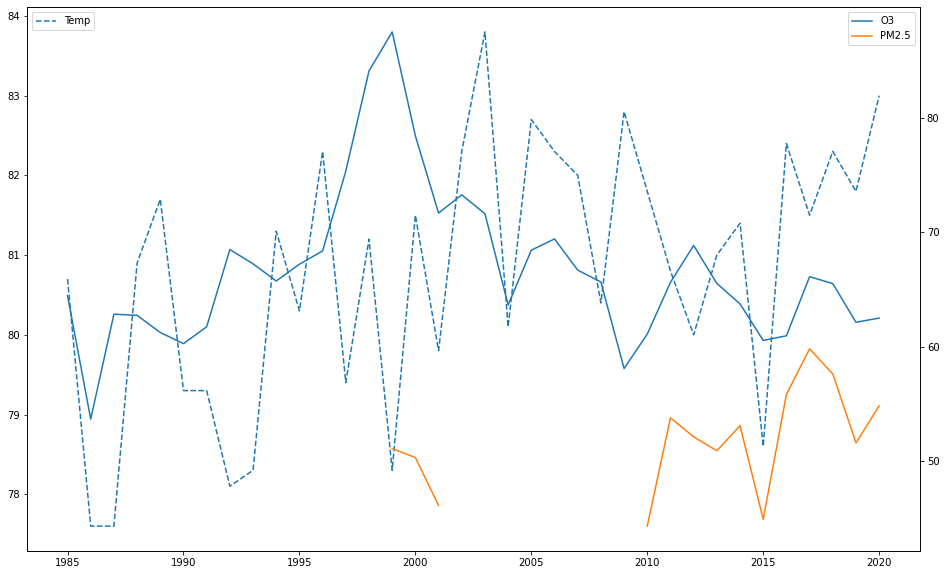

In [9]:
az_temp = pd.read_csv('/Users/smaslam/Desktop/airpollution/airpollution/Temperature/AZ-Temp.csv')
az_temp = pd.DataFrame({'date' : az_temp['Date'],
                        'Temp' : az_temp['Value']})
az_temp = az_temp.dropna()
az_temp

fig, ax1 = plt.subplots(figsize = (16, 10))
ax2 = ax1.twinx()
ax1.plot(az_temp['date'], az_temp['Temp'], '--')
az_annual['date'] = az_temp['date']
ax2.plot(az_annual['date'], az_annual['Annual Ozone'])
ax2.plot(az_annual['date'], az_annual['Annual PM2.5'])
ax1.legend(['Temp'], loc = 'upper left')
ax2.legend(['O3', 'PM2.5'], loc = 'upper right')